<a href="https://colab.research.google.com/github/seungyoonnam/AI-study/blob/main/%EC%A0%81%EB%8C%80%EC%A0%81AI%EB%AA%A8%EB%8D%B8_%EA%B3%B5%EA%B2%A9%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from __future__ import print_function
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import os
import torch.nn.functional as F
from torchvision import models, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

In [18]:
#적대적 예제 생성 후 저장할 디렉토리 생성
path='/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/0.15'
os.makedirs(path, exist_ok=True)

folders=[path+'/airplane', path+'/automobile', path+'/bird', path+'/cat', path+'/deer', path+'/dog', path+'/frog', path+'/horse', path+'/ship', path+'/truck']

for path in folders:
  os.makedirs(path, exist_ok=True)

In [19]:
#FGSM 공격함수 정의
def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad=data_grad.sign()
  perturbed_image=image+epsilon*sign_data_grad
  perturbed_image=torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

#적대적 예제 생성 및 저장 함수 정의
def ax_create(model, device, test_loader, epsilon):
  label_class="null"
  correct=0
  adv_examples=[]
  img_len=[0,0,0,0,0,0,0,0,0,0]

  loop=tqdm(enumerate(test_loader), total=len(test_loader))

  for i, data in loop:
    inputs, labels=data
    inputs, labels=inputs.to(device), labels.to(device)

    inputs.requires_grad=True

    output=model(inputs)
    init_pred=output.max(1,keepdim=True)[1]
    init_pred=init_pred.squeeze()

    loss=F.nll_loss(output, labels)
    model.zero_grad()
    loss.backward()
    data_grad=inputs.grad

    #FGSM 공격함수 호출
    perturbed_data=fgsm_attack(inputs, epsilon, data_grad)

    output=model(perturbed_data)
    final_pred=output.max(1,keepdim=True)[1]

    if final_pred.squeeze()==labels.squeeze():
      correct+=1

    adv_ex=perturbed_data.squeeze().detach().cpu().numpy()


    #적대적 예제 갯수 ax_n
    label_classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    ax_n=10

    label_index=int(labels.item())

    if label_index<len(label_classes):
      if img_len[label_index]<ax_n:
        label_class=label_classes[label_index]
        img_len[label_index]+=1
      else:
        continue

    plt.imshow(np.transpose(adv_ex, (1,2,0)))
    plt.axis('off')
    ax_path="/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/"
    plt.savefig(ax_path+str(epsilon)+'/'+label_class+'/'+str(i)+'.png', bbox_inches='tight', pad_inches=0)

Files already downloaded and verified
CUDA Available:  True


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 10000/10000 [12:47<00:00, 13.04it/s]


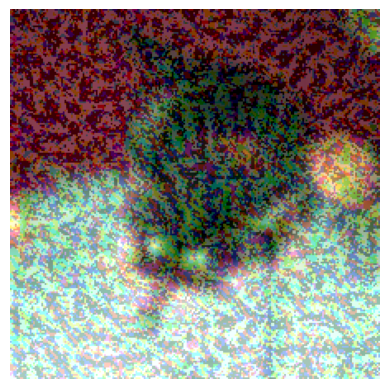

In [21]:
epsilon=0.15

trans=transforms.Compose([transforms.Resize((224, 224)),
                          transforms.ToTensor(),
                          ])

test_set=torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=trans)
test_loader=torch.utils.data.DataLoader(
    test_set, batch_size=1, shuffle=False, num_workers=0)

#GPU 할당
print("CUDA Available: ", torch.cuda.is_available())
device=torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

#타깃모델 load
model=models.resnet50(pretrained=True)
num_classes=10
num_ftrs=model.fc.in_features
model.fc=nn.Linear(num_ftrs, num_classes)

#타깃모델가중치 load
path="/content/drive/MyDrive/Colab Notebooks/Cifar_Best_resnet50.pth"
model.load_state_dict(torch.load(path))

model.to(device)
model.eval()

#적대적예제생성함수 호출
acc=ax_create(model, device, test_loader, epsilon)

In [27]:
#정확도 검증
def model_test_visualization(test_set):
  test_loader=torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)
  my_data=[]
  y_pred_list=[]

  for i, (input, target)in enumerate(test_loader):
    my_data.append(target)

  with torch.no_grad():
    for X_batch, _ in test_loader:
      X_batch=X_batch.to(device)
      y_test_pred=model(X_batch)
      y_pred_softmax=torch.log_softmax(y_test_pred, dim=1)
      _, y_pred_tags=torch.max(y_pred_softmax, dim=1)
      y_pred_list.append(y_pred_tags.cpu().numpy())

  y_pred_list=[a.squeeze().tolist() for a in y_pred_list]
  my_data=[a.squeeze().tolist() for a in my_data]

  answer=[]
  for element in my_data:
    answer.append(element)
  question=[]
  for element in y_pred_list:
    question.append(element)

  my_data=torch.tensor(answer)
  y_pred_list=torch.tensor(question)

  #Confusion-matrix 출력
  confusion_mx=pd.DataFrame(confusion_matrix(my_data, y_pred_list))
  ax=sns.heatmap(confusion_mx, annot=True, fmt='g')
  plt.title('ResNet Confusion Matrix', fontsize=20)
  plt.show()

  f1_score_detail=classification_report(my_data, y_pred_list)
  print(f1_score_detail)

  print(f"precision : {precision_score(my_data, y_pred_list, average='macro')}")
  print(f"recall : {recall_score(my_data, y_pred_list, average='macro')}")
  print(f"f1 score : {f1_score(my_data, y_pred_list, average='macro')}")
  print(f"accuracy : {accuracy_score(my_data, y_pred_list)}")


In [28]:
#정상 테스트셋 load 및 test 함수
def original_test():
  print("")
  print("******* Original Dataset Test *******")
  print("")
  test_set=torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=trans)
  model_test_visualization(test_set)

In [29]:
#적대적예제 테스트셋 load 및 test 함수
def adversarial_test():
  print("")
  print("******* Adversarial Example Test *******")
  print("")
  ax_example_path="/content/drive/MyDrive/Colab Notebooks/ResNet_FGSM/test/0.15/"
  test_set=torchvision.datasets.ImageFolder(root=ax_example_path, transform=trans)
  model_test_visualization(test_set)


******* Original Dataset Test *******

Files already downloaded and verified


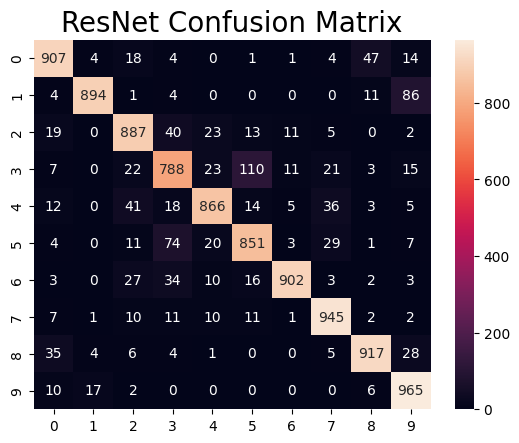

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1000
           1       0.97      0.89      0.93      1000
           2       0.87      0.89      0.88      1000
           3       0.81      0.79      0.80      1000
           4       0.91      0.87      0.89      1000
           5       0.84      0.85      0.84      1000
           6       0.97      0.90      0.93      1000
           7       0.90      0.94      0.92      1000
           8       0.92      0.92      0.92      1000
           9       0.86      0.96      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

precision : 0.8937872023092146
recall : 0.8922000000000001
f1 score : 0.8922637432848417
accuracy : 0.8922


In [30]:
#test 함수 호출
original_test()


******* Adversarial Example Test *******



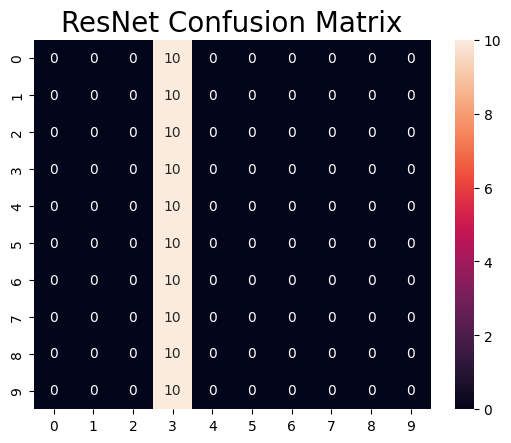

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        10
           3       0.10      1.00      0.18        10
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        10
           8       0.00      0.00      0.00        10
           9       0.00      0.00      0.00        10

    accuracy                           0.10       100
   macro avg       0.01      0.10      0.02       100
weighted avg       0.01      0.10      0.02       100

precision : 0.01
recall : 0.1
f1 score : 0.01818181818181818
accuracy : 0.1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [31]:
#test 함수 호출(적대적 예제)
adversarial_test()